# Performing combined approximation, continuity and energy objective optimization experiments

In this Jupyter notebook we perform tests for our ARW paper.

Version 0.1  
Date: 2025-03-04  
Current version: hannes.waclawek@fh-salzburg.ac.at  

In [2]:
import copy

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pickleshare import PickleShareDB
db = PickleShareDB('./picklesharedb')

%load_ext autoreload
%autoreload 2

# Energy minimization

In order to reduce the forces applied to a cam-follower system, we want to optimize the cam's acceleration curve.
To do so, we can quantify total curvature as

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
\end{align*}

for a cam profile $f$ over the interval $I$.
Considering our individual polynomial segments $p_i$, we receive

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
      &= \sum_{i=1}^m \int_{I_i} p''_i(x)^2 \; \mathrm{d}x
\end{align*}

with
\begin{align*}
    & \int_{I_i} p''_i(x)^2 \; \mathrm{d}x \\
    &= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right)^2  \; \mathrm{d}x \\
    %&= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right) \cdot \\
    %&  \quad \left( \sum_{k=2}^d \alpha_{i,k} \cdot k (k-1) x^{k-2} \right) \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1) \cdot
        \int_{I_i} x^{j+k-4} \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \frac{\alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1)}{j+k-3}
        \cdot \left. x^{j+k-3} \right|_{\xi_{i-1}}^{\xi_i}
\end{align*}

representing total acceleration for each individual polynomial segment.
Plugging in the boundary points for the definite integral and generalizing 
to the overall spline with $m$ segments we can then formulate total curvature loss as 

\begin{align*}
    \ell_\text{E} = \sum_{i=1}^m \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} \frac{j k (j-1) (k-1)}{j+k-3}
        \cdot \left(\xi_i^{j+k-3}-\xi_{i-1}^{j+k-3}\right). \\
\end{align*}

# 3-objective optimization

Previously, we optimized for continuity error $\ell_{\text{CK}}$ and approximation error $\ell_2$ utilizing the loss function

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + (1-\alpha) \ell_2,
\end{align}

with $0 \le \alpha \le 1$. 

We now have three objectives, $\ell_2, \ell_{\text{CK}}, \ell_{\text{E}}$,
and still want to weight them in a way that the sum of the weights equals $1$.  
Therefore, we introduce two independent parameters \( \alpha \) and \( \beta \),
and define the weighted sum as:  

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + \beta \ell_2 + (1-\alpha-\beta) \ell_{\text{E}},
\end{align}

where $\alpha, \beta \geq 0$ and $\alpha + \beta \leq 1$.  
   
- $\alpha$ controls the emphasis on $\ell_{\text{CK}}$  
- $\beta$ controls the emphasis on $\ell_2$  
- The remaining weight $(1 - \alpha - \beta)$ is assigned to $\ell_{\text{E}}$ 
- If $\alpha + \beta = 1$, then $\ell_{\text{E}}$  has no weight  
- If $\alpha + \beta = 0$, then only $\ell_{\text{E}}$ is considered  

# What we know from previous findings

## General

Continuity optimization works and results converge.

## Alpha

We increase alpha with rising variance as more emphasis on continuity optimization is required:
- Simple rise: 0.1
- Sine: 0.1
- Sine with varying frequency: 0.6
- Noisy Sine with varying frequency: 0.999

## Learning rate and number of epochs  
 
Contrary to the single approximation target we see that a lower learning rate of 0.1 is beneficial.
Also contrary to the single approximation target, the combined C^k and approximation goal now leads to a non-convex loss landscape
and we see spikes in the loss curve at some epoch ranges. This is expected, if optimization leaves a local optima towards a lower optimum.
Early stopping and reverting to the best loss / coefficients of the training cycle can prevent ending up with an unsatisfiable local optimum result.

**A learning rate of 0.1 seems to be a reasonable choice for all bases.**
**2000 epochs seem to be sufficient. With early stopping we can have less.**
  
## Number of polynomials
  
Raising the number of polynomials, as expected, reduces remaining losses and, for Chebyshev basis, shows less spikes in remaining losses.
If we increase the number of segments, the variance in the individual segments input data is effectively decreased.  
A learning rate of 0.1 still is good for more polynomials. 

## Optimizers  
  
Chebyshev basis is clearly outperforming Power Basis in regard to all observed optimizers and input point sets.
**None of the optimizers manage to surpass the l2 optimum with Power basis in the given 5000 epochs for the lowest variance input data (name in this notebook: Simple rise curve).**
**There are, however, several optimizers that achieve this with Chebyshev basis.**
The more variance is in the input data, the higher is the loss for the l2 baseline with CK loss.
The more variance is in the input data, the more optimizers (also with Power basis) manage to surpass this l2 baseline.
The following optimizer candidates surpass the l2 baseline with all observed input data:
1. adam, amsgrad
2. adamax
3. adagrad, ftrl
4. nadam

Considering all observed input data, Adam AMSGrad is the best candidate.
With least squares fit initialization of polynomial coefficients, Power basis gets competitive again.
However, Chebyshev basis with AMSGrad still shows the best convergence behaviour also in that scenario.

## AMSGrad optimizer parameters

Default parameters perform best for Power and Chebyshev basis.

## $C^k$ loss regularization

Results with $C^k$ loss regularization outperform results without $C^k$ loss regularization for all candidate optimizers.
The more variance is in the input data, the closer is the gap. 


## Data

We seek data were optimizing for $\ell_{\text{CK}}$ and $\ell_{\text{E}}$ is not sufficient to produce a "smooth" result.
We want to base our argument on one of two cases:
 - Trajectories that contain measuring errors (i.e. noise)
 - Trajectories that are not $C^k$ continuous and therefore an approximation thereof is prone to oscillating behaviour

In both cases we expect unwanted oscillation in the result that can be smoothened out via $\ell_{\text{E}}$.

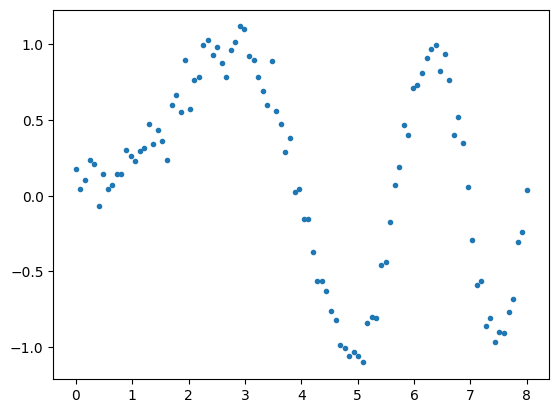

In [3]:
xs2 = np.linspace(0, 1, 100)
ysinvar = np.sin(xs2**2 * 4 * np.pi)
xs2 = sampledata.rescale_input_data(xs2, 8)

# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scale = 0.1
ys2 = ysinvar + np.random.normal(scale=ys2gauss_scale, size=len(ysinvar))

plt.plot(xs2, ys2, '.')

## Test approximations 

We use $C^2$-continuity to have more free parameters.

In [5]:
ck = 2
polynum=16
degree = 7
learning_rate = 0.1
ck_regularization=False
cyclic=True
patience=100

In [6]:
alpha = 0.9
beta = 0.1
epochs=1000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate)

pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=patience, ck_regularization=ck_regularization, cyclic=cyclic)
db["loss_xs2_no_energy_optimization_16seg"] = pp.get_total_loss()
db["coeffs_xs2_no_energy_optimization_16seg"] = pp.coeffs

c:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\IPython\core\events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


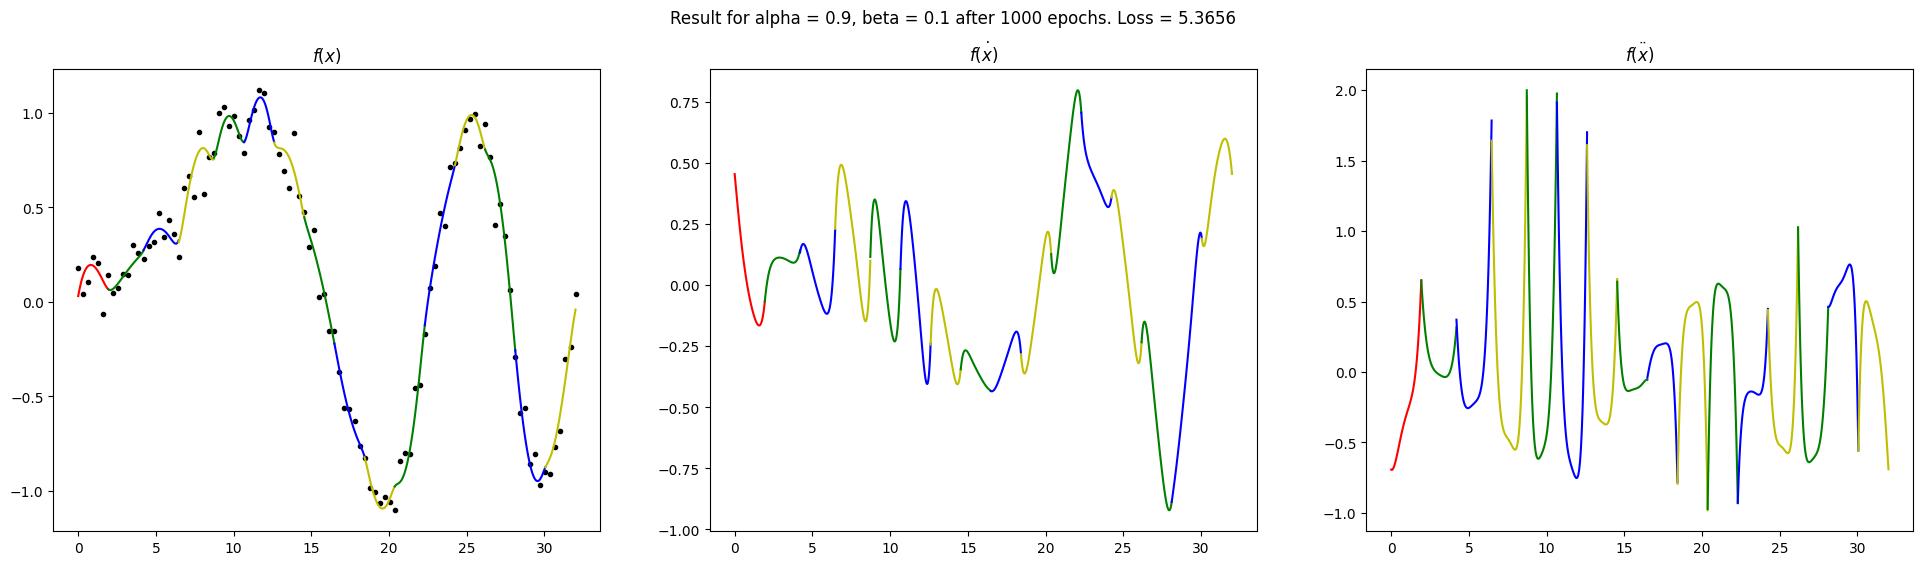

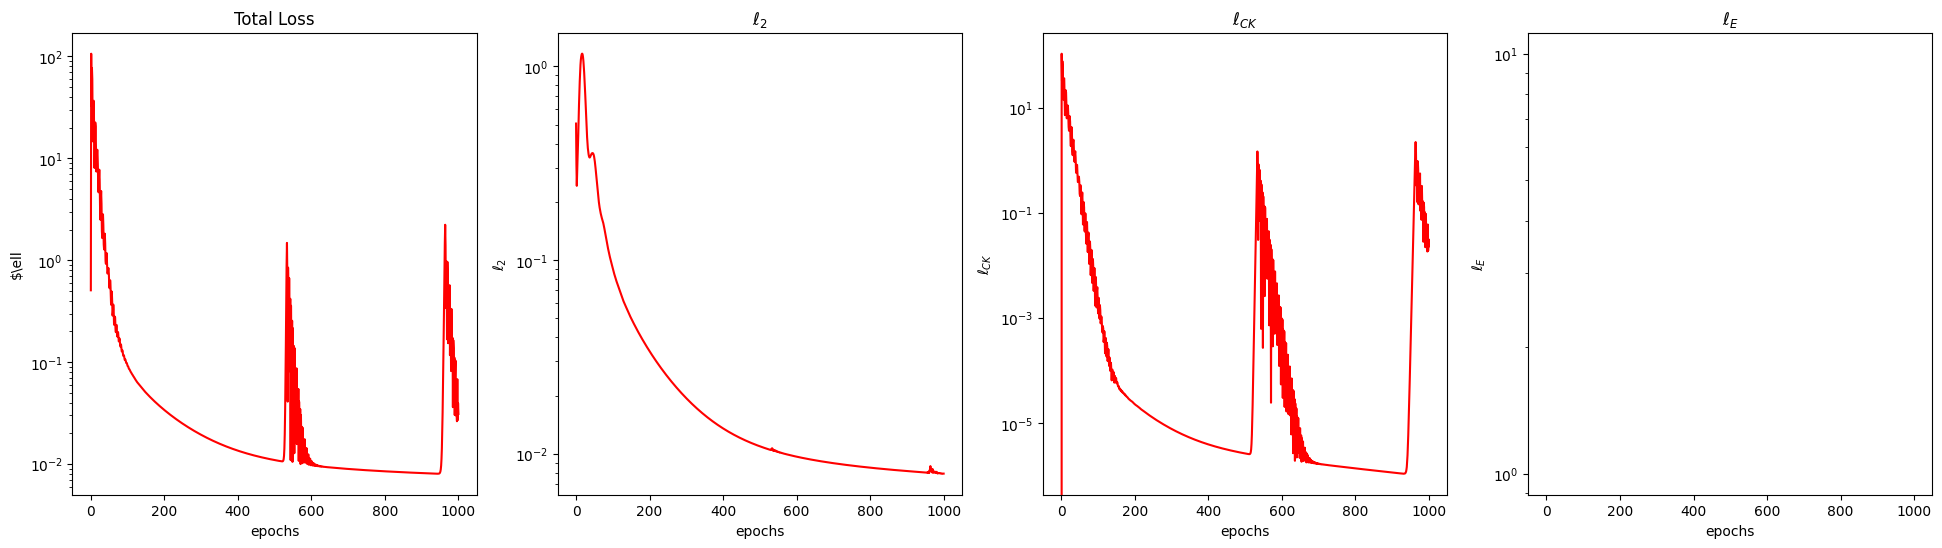

In [7]:
loss = db["loss_xs2_no_energy_optimization_16seg"] 

fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss[0]:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [8]:
alpha = 0.9
beta = 0.099
epochs=1000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate)

pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=patience, ck_regularization=ck_regularization, cyclic=cyclic)
db["loss_xs2_with_energy_optimization_16seg"] = pp.get_total_loss()
db["coeffs_xs2_with_energy_optimization_16seg"] = pp.coeffs

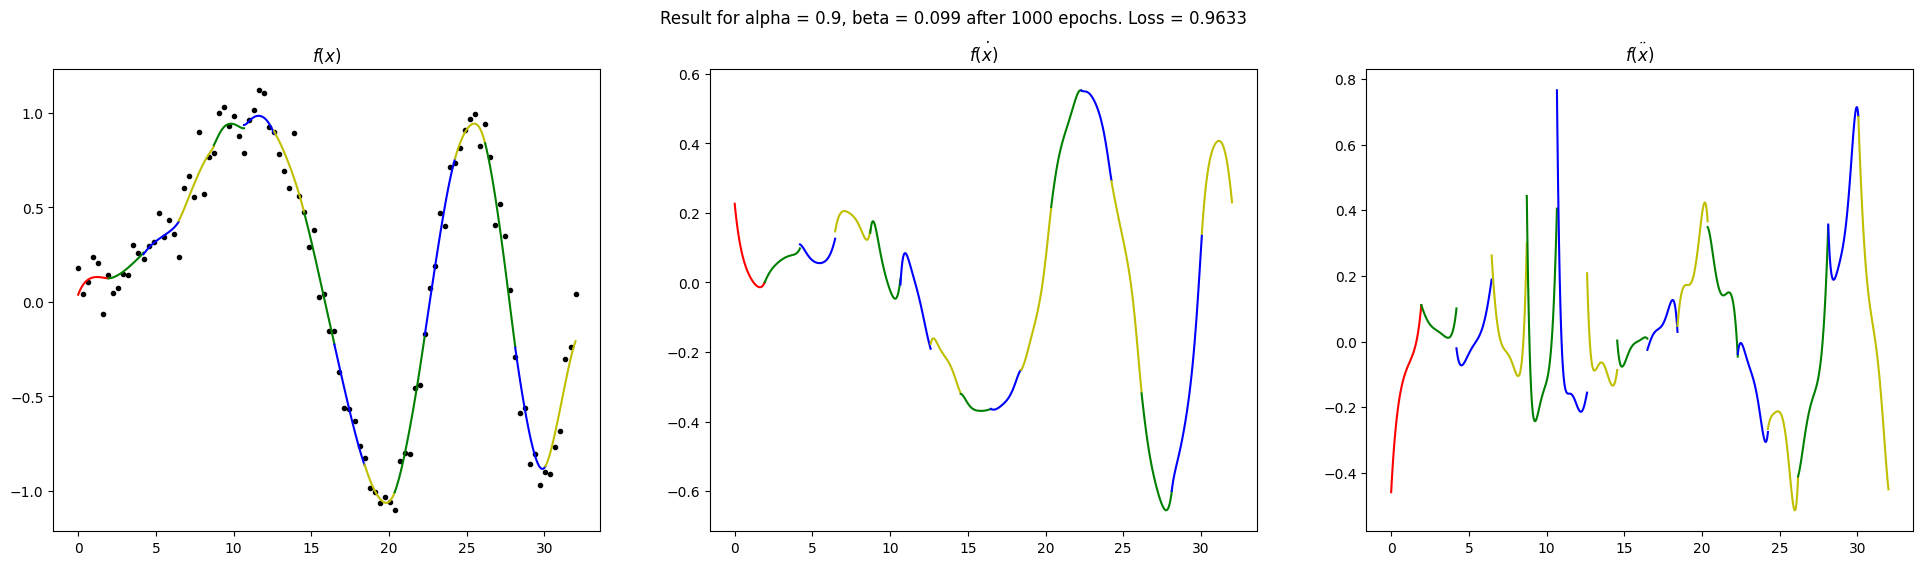

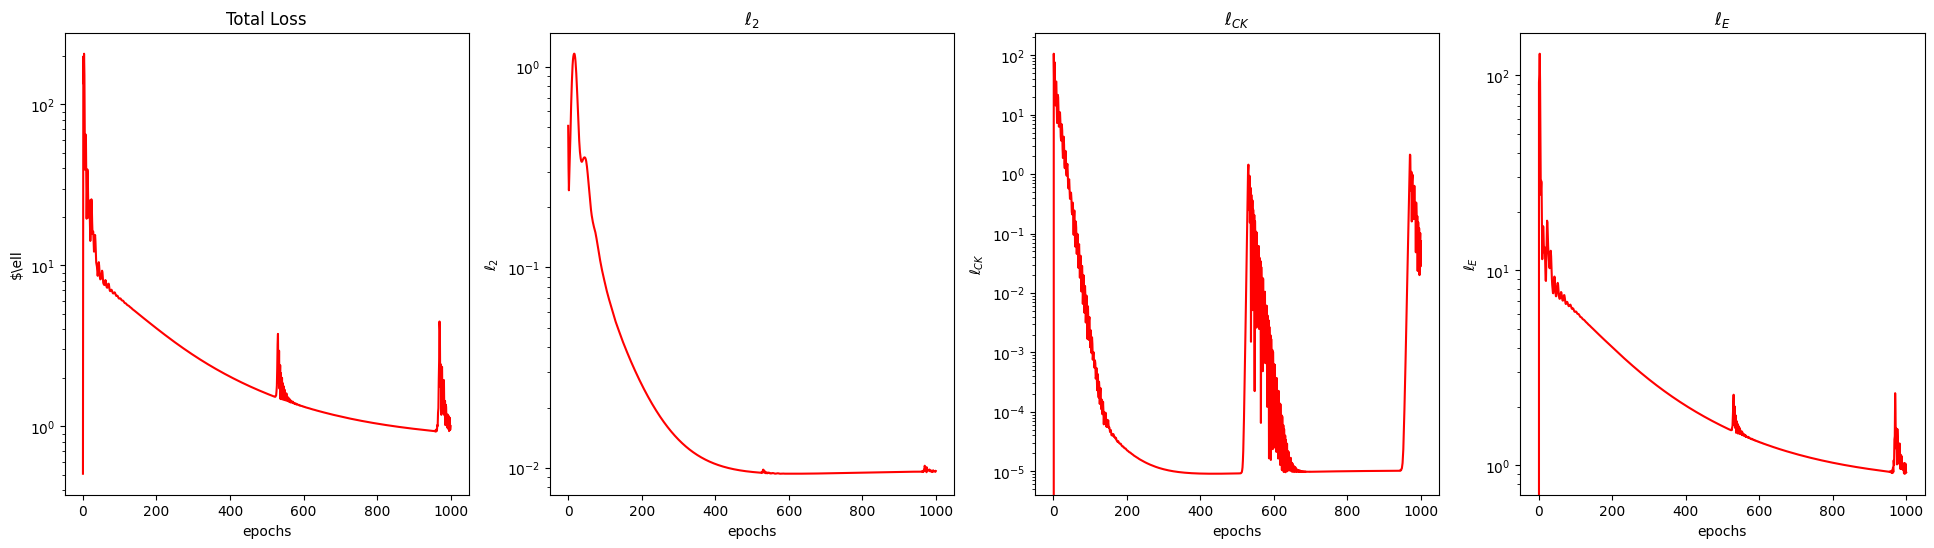

In [9]:
loss = db["loss_xs2_with_energy_optimization_16seg"] 

fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss[0]:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

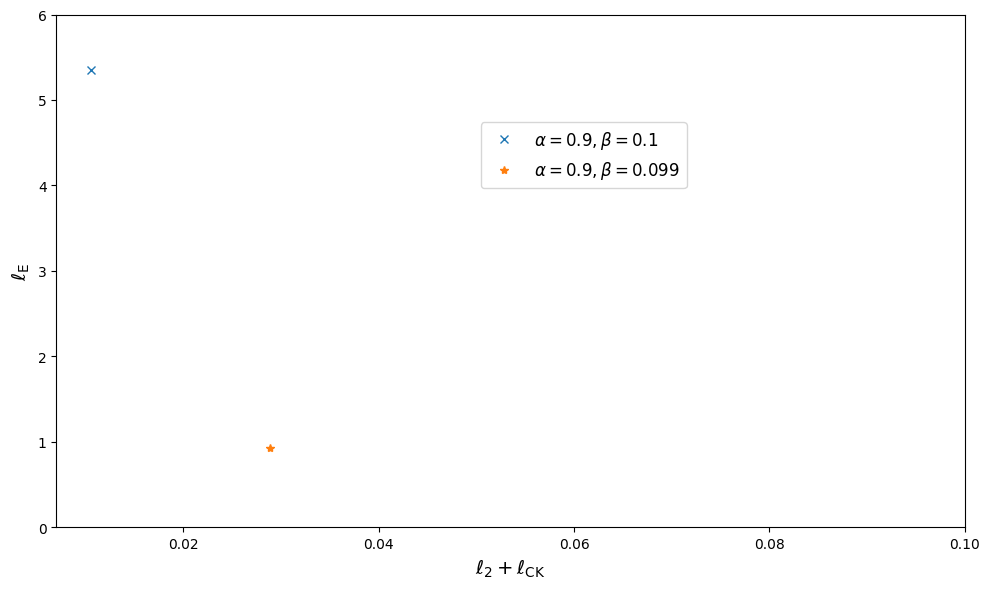

In [15]:
loss_without = db["loss_xs2_no_energy_optimization_16seg"] 
loss_with = db["loss_xs2_with_energy_optimization_16seg"] 

fig, ax = plt.subplots() 
fig.set_figwidth(10)
fig.set_figheight(6)
#fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss[0]:.4f}')

ax.plot(loss_without[1]+loss_without[2], loss_without[3], 'x', label=r'$\alpha = 0.9, \beta = 0.1$')
ax.plot(loss_without[1]+loss_with[2], loss_with[3], '*', label=r'$\alpha = 0.9, \beta = 0.099$')
ax.set_xlabel(r'$\ell_2+\ell_\mathrm{CK}$', fontsize=14)
ax.set_ylabel(r'$\ell_\mathrm{E}$', fontsize=14)
ax.set_xlim([0.007, 0.1])
ax.set_ylim([0, 6])

fig.legend(loc='upper right', bbox_to_anchor=(0.7, 0.80), fontsize=12)
fig.tight_layout()
#fig.suptitle(r'$x_{k-1}$ and excessive velocity $\dot{x}(t_*)$ over $C$ at $x_0=$' f' {start_loc}.' '\n' r'Left wall at $x~=-1.5$', y=1.1)  # otherwise the right y-label is slightly clipped
plt.savefig(".\\experimental-result.pdf")

In [11]:
loss_with

(<tf.Tensor: shape=(), dtype=float64, numpy=0.9632506843721681>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.009595367678953463>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.02101403616802427>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9326412805251904>)

In [12]:
loss_without

(<tf.Tensor: shape=(), dtype=float64, numpy=5.3655749264135855>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.007899385427018358>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.002623966159444884>,
 <tf.Tensor: shape=(), dtype=float64, numpy=5.355051574827122>)

### Interpretation

$\ell_E$ optimization works and reduces oscillations in the resulting curve.  
Given this input data, we receive a cam curve introducing less forces and therefore energy consumption.  
Less oscillating behaviour also potentially reduces vibrations in an industrial machine executing the cam profile, therefore reducing wear of machine parts.  
We could still perform hyperparameter optimization here, to e.g. decrease $C^k$-loss.  